# PACE validation analysis

## Using AVW + QWIP to summarize spectral differences

Howdy! This exercise walks through a comparison of PACE + field derived remote sensing reflectance intended for satellite validation. The idea is to screen the data for outliers, find the indices for all spectra that are deemed appropriate for matchups, and then characterize the differences in a holistic manner. This analysis utilizes the Apparent Visible Wavelength (AVW) from [Vandermeulen et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0034425720302704) and the Quality Water Index Polynomial (QWIP) from [Dierssen et al. (2022)](https://www.frontiersin.org/journals/remote-sensing/articles/10.3389/frsen.2022.869611/full). 

Note - the analyses solely utilize the visible range of Rrs spectra, and thus exclude the UV. Though, the QC criteria is set to examine the entire visible spectra, so a bad visible spectra would not likely be used for UV validation. 

In [2]:
# Import the data matchups

import pandas as pd
df = pd.read_csv("A_matchupAOP_unconstrained_1.csv")
print(df.columns)

Index(['FIELD_datetime', 'FIELD_index', 'FIELD_lat', 'FIELD_lon',
       'FIELD_env_file', 'FIELD_Rrs315', 'FIELD_Rrs320', 'FIELD_Rrs325',
       'FIELD_Rrs330', 'FIELD_Rrs335',
       ...
       'PACE_sena', 'PACE_senz', 'PACE_sola', 'PACE_solz', 'PACE_water_vapor',
       'PACE_windspeed', 'PACE_valid_pixels', 'PACE_cv',
       'PACE_pixel_percentage', 'PACE_time_diff'],
      dtype='object', length=381)


In [3]:
# House-keeping, importing the various fields

import numpy as np
import xarray as xr
import re

metadata_cols = ['FIELD_datetime', 'FIELD_index', 'FIELD_lat', 'FIELD_lon', 'FIELD_env_file']

rrsfield_cols = [col for col in df.columns if col.startswith("FIELD_Rrs") and "_unc" not in col]
rrsfield_unc_cols = [col for col in df.columns if col.startswith("FIELD_Rrs") and "_unc" in col]
rrspace_cols = [col for col in df.columns if col.startswith("PACE_Rrs") and "_unc" not in col]
rrspace_unc_cols = [col for col in df.columns if col.startswith("PACE_Rrs") and "_unc" in col]

wavelengths_field = np.array([int(re.search(r'\d+', col).group()) for col in rrsfield_cols])
mask_field = (wavelengths_field >= 400) & (wavelengths_field <= 700)
wavelengths_field_vis = wavelengths_field[mask_field]

wavelengths_pace = np.array([int(re.search(r'\d+', col).group()) for col in rrspace_cols])
mask_pace = (wavelengths_pace >= 400) & (wavelengths_pace <= 700)
wavelengths_pace_vis = wavelengths_pace[mask_pace]

rrsfield = df[np.array(rrsfield_cols)[mask_field]].to_numpy()
rrsfield_unc = df[np.array(rrsfield_unc_cols)[mask_field]].to_numpy()
rrsPACE = df[np.array(rrspace_cols)[mask_pace]].to_numpy()
rrsPACE_unc = df[np.array(rrspace_unc_cols)[mask_pace]].to_numpy()

In [4]:
# A few functions to calculate AVW, brightness, and generate QWIP scores

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.integrate import trapezoid

def calc_avw(wavelengths, rrs):
    # Calculates the Apparent Visible Wavelength
    return np.sum(rrs, axis=1) / np.sum(rrs / wavelengths, axis=1)


def calc_brightness(wavelengths, rrs):
    # Calculates the integrated brightness using the trapezoidal rule
    return trapezoid(y=rrs, x=wavelengths, axis=-1)


def process_qwip_data(wavelengths, rrs, avw):
    # Calcualtes QWIP scores, used for subsequent plotting
    
    # Find the index of the wavelengths we need
    idx_490 = np.argmin(np.abs(wavelengths - 490))
    idx_560 = np.argmin(np.abs(wavelengths - 560))
    idx_665 = np.argmin(np.abs(wavelengths - 665))

    # Calculate the Normalized Difference Index
    NDI = (rrs[:, idx_665] - rrs[:, idx_490]) / (rrs[:, idx_665] + rrs[:, idx_490])

    # Define the polynomial coefficients and the range to evaluate the fit
    p = np.array([-8.399885e-09, 1.715532e-05, -1.301670e-02, 4.357838, -5.449532e02])
    avw_poly = np.arange(440, 600) # np.arange is exclusive of the stop value
    fit1 = np.polyval(p, avw_poly)

    # Create boolean masks to classify the data based on reflectance properties via Balasubramanian (2020)
    Step1 = rrs[:, idx_665] > rrs[:, idx_560]
    Step2 = rrs[:, idx_665] > 0.025
    Step3 = rrs[:, idx_560] < rrs[:, idx_490]

    ind_600A = Step1 | Step2
    ind_500A = (~Step1 & ~Step2) & ~Step3
    ind_400A = (~Step1 & ~Step2) & Step3

    # Calculate predicted NDI from the polynomial fit and the final QWIP score
    NDI_pred = np.polyval(p, avw)
    QWIP_score = NDI - NDI_pred

    # --- Classification Logic ---

    # Water type-based failure flags
    failed_400 = ind_400A & ((avw < 410) | (avw > 520))
    failed_500 = ind_500A & ((avw < 490) | (avw > 590))
    failed_600 = ind_600A & ((avw < 550) | (avw > 600))

    # Combine all type-based failure conditions
    type_failure = failed_400 | failed_500 | failed_600
    qwip_failure = (QWIP_score < -0.2) | (QWIP_score > 0.2)
    is_failed = type_failure | qwip_failure 

    # 4. Get the indices for failed and passed locations
    failed_indices = np.where(is_failed)[0]
    passed_indices = np.where(~is_failed)[0]

    #print(f"Number of samples that failed: {len(failed_indices)}")
    #print(f"Number of samples that passed: {len(passed_indices)}")
    #print(f"Failed indices: {failed_indices[:]}")

    results = {
    'avw': avw,
     'NDI': NDI,
     'ind_400A': ind_400A,
     'ind_500A': ind_500A,
     'ind_600A': ind_600A,
     'poly_coeffs': p,
     'failed_indices': failed_indices,
     'passed_indices': passed_indices
}
    return results


def plot_qwip(results, title="QWIP Analysis"):
    # Generates the QWIP plot from processed data.
    
    # Unpack the results dictionary
    avw = results['avw']
    NDI = results['NDI']
    ind_400A = results['ind_400A']
    ind_500A = results['ind_500A']
    ind_600A = results['ind_600A']
    p = results['poly_coeffs']

    # Calculate polynomial fit for plotting
    avw_poly = np.arange(400, 631)
    fit1 = np.polyval(p, avw_poly)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title, fontsize=18, fontweight='bold')

    # Plot the classified data points
    ax.plot(avw[ind_400A], NDI[ind_400A], 'ok', markersize=5, markerfacecolor='b', label='Type I Blue-Green')
    ax.plot(avw[ind_500A], NDI[ind_500A], 'ok', markersize=5, markerfacecolor='g', label='Type II Green')
    ax.plot(avw[ind_600A], NDI[ind_600A], 'ok', markersize=5, markerfacecolor='r', label='Type III Brown')

    # Plot the polynomial fit and threshold lines
    ax.plot(avw_poly, fit1,       '-k', linewidth=2)
    ax.plot(avw_poly, fit1 + 0.1, '--g', linewidth=2)
    ax.plot(avw_poly, fit1 - 0.1, '--g', linewidth=2)
    ax.plot(avw_poly, fit1 + 0.2, '--', linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 - 0.2, '--', linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 + 0.3, '--', linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 - 0.3, '--', linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 + 0.4, '-r', linewidth=2)
    ax.plot(avw_poly, fit1 - 0.4, '-r', linewidth=2)

    # --- Formatting and Legends ---
    ax.set_xlabel('AVW (nm)', fontsize=16)
    ax.set_ylabel('NDI (490, 665)', fontsize=16)
    ax.set_ylim(-2.5, 2)
    ax.set_xlim(440, 600)
    ax.grid(True, linestyle=':', alpha=0.6)

    # Create the two separate legends
    legend1 = ax.legend(loc='lower right', title='Data Types', fontsize=12)
    ax.add_artist(legend1)

    legend_lines = [
        Line2D([0], [0], color='g', lw=2, linestyle='--', label='QWIP ± 0.1'),
        Line2D([0], [0], color=(0.9290, 0.6940, 0.1250), lw=2, linestyle='--', label='QWIP ± 0.2'),
        Line2D([0], [0], color=(0.8500, 0.3250, 0.0980), lw=2, linestyle='--', label='QWIP ± 0.3'),
        Line2D([0], [0], color='r', lw=2, linestyle='-', label='QWIP ± 0.4')
    ]
    ax.legend(handles=legend_lines, loc='upper left', title='Thresholds', fontsize=12)

    plt.show()


def plot_normalized_spectra(results, wavelengths, rrs, brightness, title_suffix=""):
    #Plots normalized spectra for passed and failed data, color-coded by AVW.

    # --- Data Preparation ---
    # Normalize Rrs by brightness. Add a new axis to brightness for broadcasting.
    normalized_rrs = rrs / brightness[:, np.newaxis]
    
    passed_indices = results['passed_indices']
    failed_indices = results['failed_indices']
    avw = results['avw']
    
    # --- Plotting Setup ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle(f'Normalized Spectra - {title_suffix}', fontsize=18, fontweight='bold')
    
    # Set up the colormap and normalization for AVW values
    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(vmin=440, vmax=600)
    
    # --- Passed Spectra Plot ---
    ax1.set_title(f'Passed Spectra ({len(passed_indices)})', fontsize=14)
    if len(passed_indices) > 0:
        for i in passed_indices:
            color = cmap(norm(avw[i]))
            ax1.plot(wavelengths, normalized_rrs[i, :], color=color, alpha=0.6)
    ax1.set_xlabel('Wavelength (nm)', fontsize=12)
    ax1.set_ylabel('Normalized Rrs (Rrs / Brightness)', fontsize=12)
    ax1.set_ylim(top=0.015)
    ax1.axhline(0, color='k', linestyle='--', linewidth=1.5) 
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Failed Spectra Plot ---
    ax2.set_title(f'Failed Spectra ({len(failed_indices)})', fontsize=14)
    if len(failed_indices) > 0:
        for i in failed_indices:
            color = cmap(norm(avw[i]))
            ax2.plot(wavelengths, normalized_rrs[i, :], color=color, alpha=0.6)
    ax2.set_xlabel('Wavelength (nm)', fontsize=12)
    ax2.set_ylim(top=0.015)
    ax2.axhline(0, color='k', linestyle='--', linewidth=1.5)
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- Colorbar ---
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.05)
    cbar.set_label('AVW (nm)', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


## Alright, let's get plotting! 

The first plot generated will show the AVW v. NDI, which closely follows a polynomial as defined in Dierrsen et al. (2022). When a spectrum fall outside of that polynomial range (> |0.2|), it is flagged as being... abby-normal. As a sanity check, we subsequently isolate those indices and plot all the spectra that pass/fail (color-coded as a function of AVW). We do this for FIELD data first, then PACE data. 

Afterwards, a diagnostic output shows how many spectra passed/failed the QWIP analysis for both datasets. The philosophy is, if the entire spectra itself is suspect in quality, we probably don't want to use any of those wavelengths for validation.

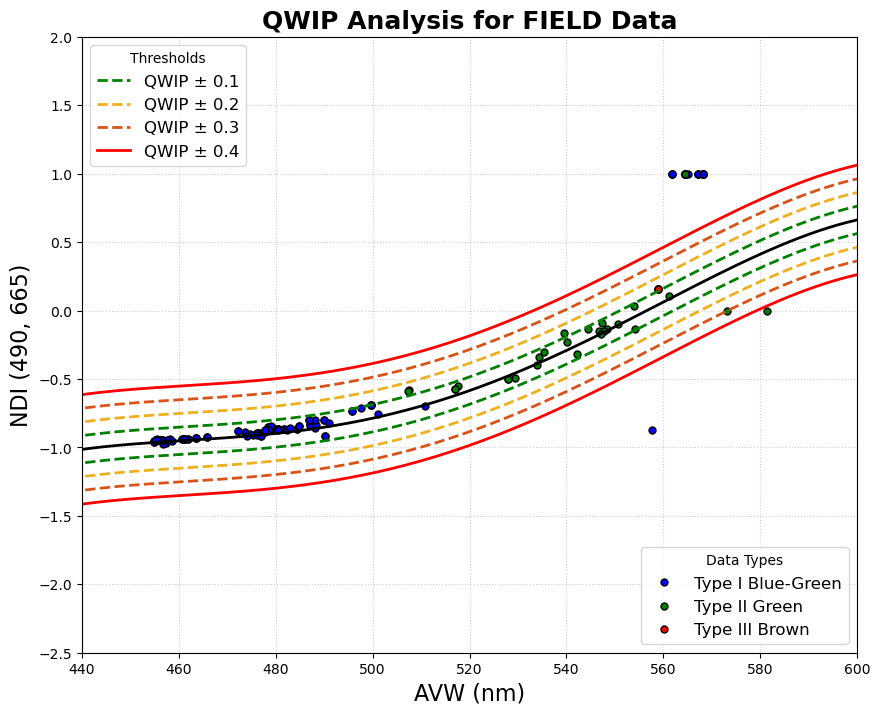

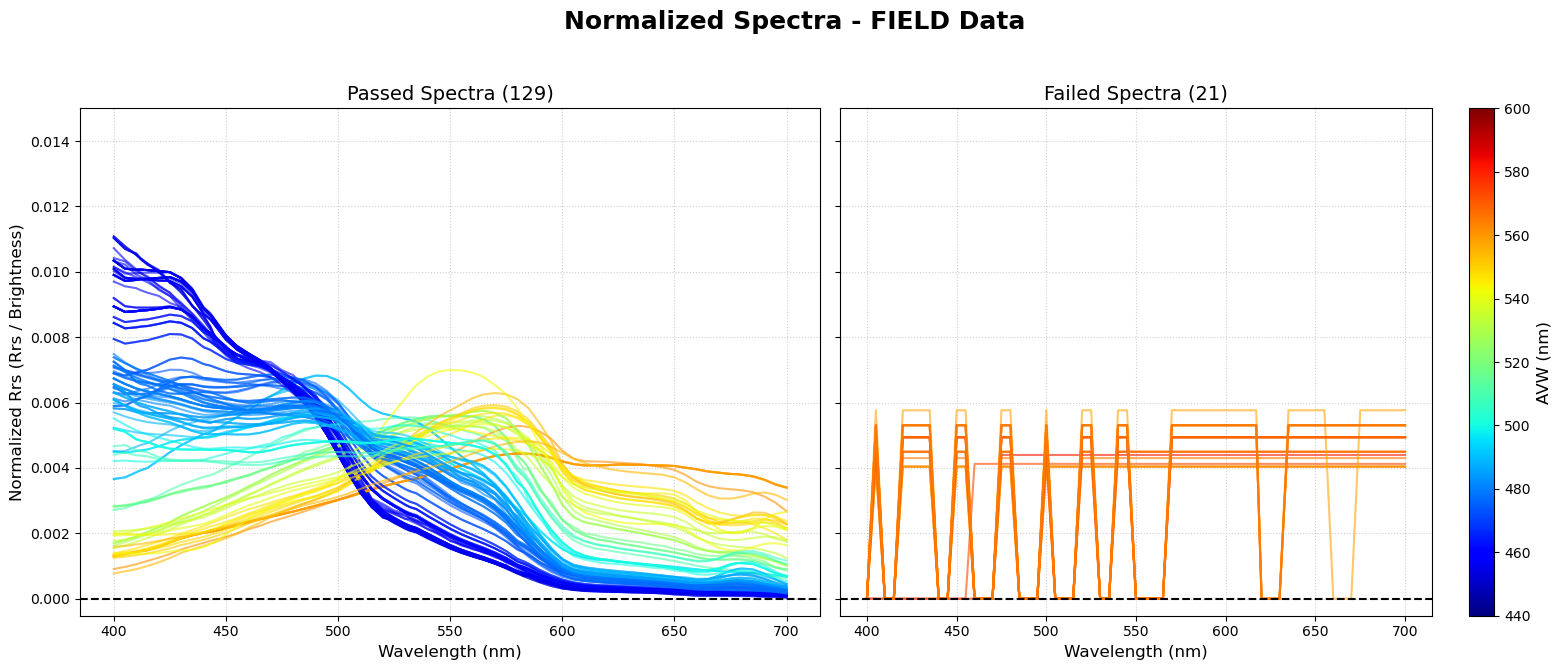

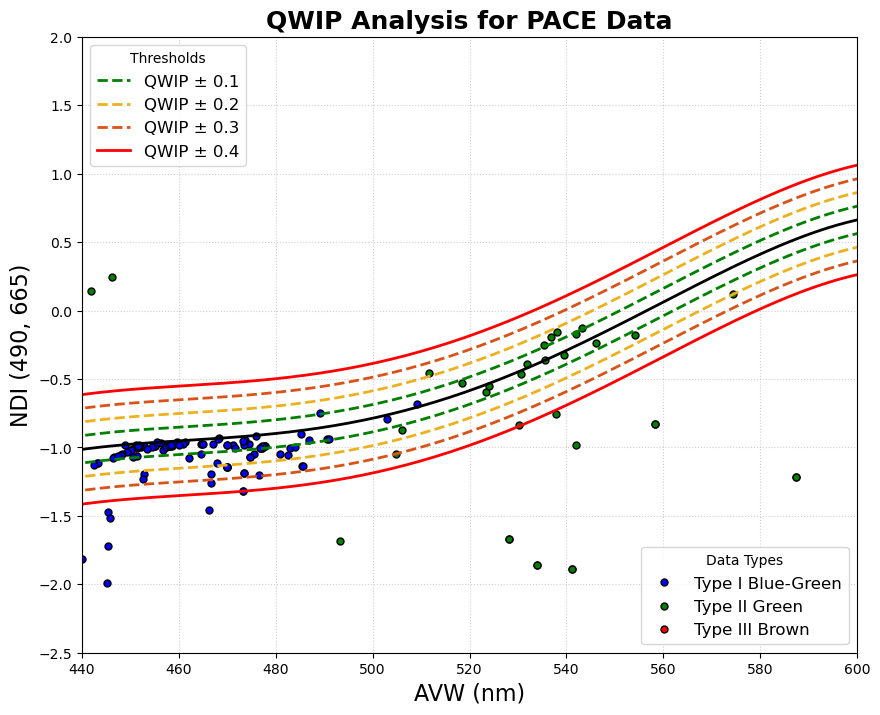

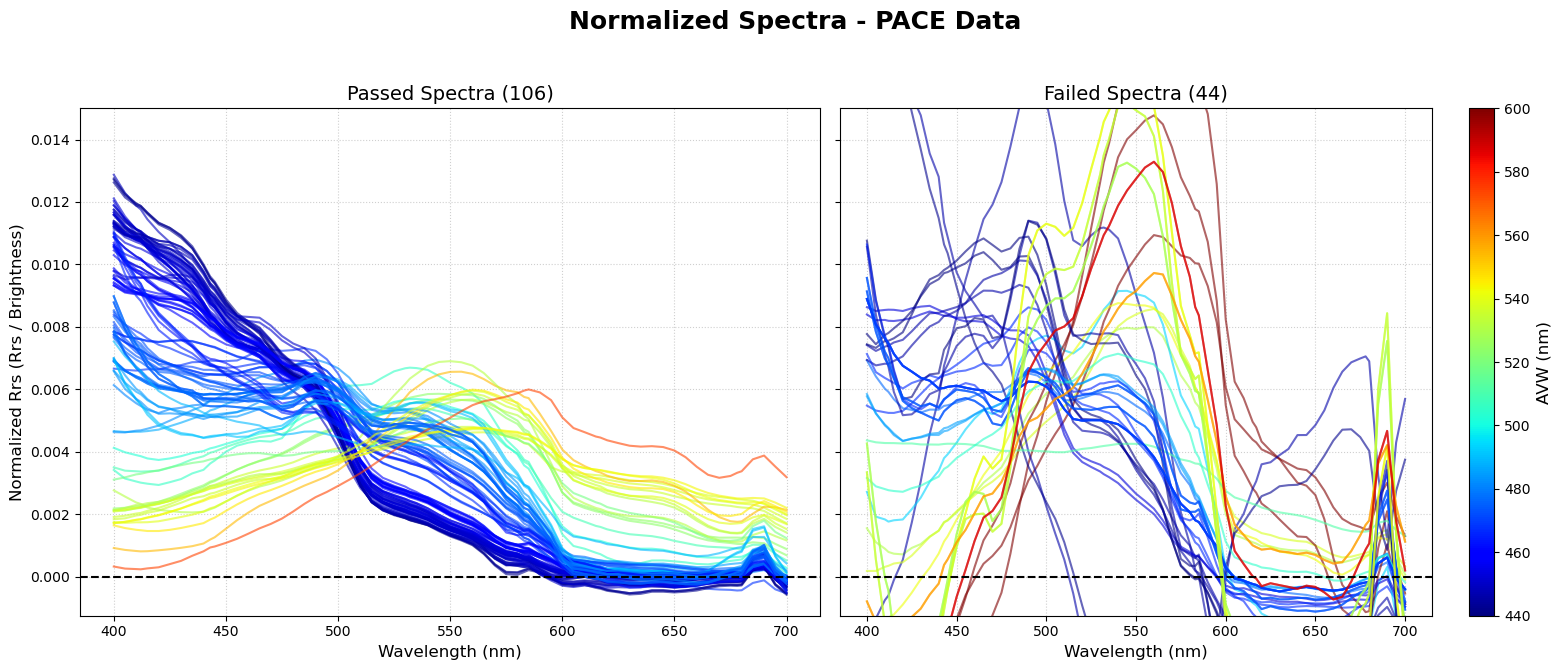


Total spectra that failed either qwip test: 54
Total spectra that failed BOTH qwip tests: 11
Total spectra that passed BOTH qwip tests: 96


In [5]:
# Calculate AVW for each dataset
avw_field = calc_avw(wavelengths_field_vis, rrsfield)
avw_PACE = calc_avw(wavelengths_pace_vis, rrsPACE)

# Calculate brightness for each dataset
brightness_field = calc_brightness(wavelengths_field_vis, rrsfield)
brightness_PACE = calc_brightness(wavelengths_pace_vis, rrsPACE)

# Calculate QWIP score
qwip_results_field = process_qwip_data(wavelengths_field_vis, rrsfield, avw_field)
plot_qwip(qwip_results_field, title="QWIP Analysis for FIELD Data")
plot_normalized_spectra(qwip_results_field, wavelengths_field_vis, rrsfield, brightness_field, title_suffix="FIELD Data")

# --- Run Analysis for PACE Data ---
qwip_results_pace = process_qwip_data(wavelengths_pace_vis, rrsPACE, avw_PACE)
plot_qwip(qwip_results_pace, title="QWIP Analysis for PACE Data")
plot_normalized_spectra(qwip_results_pace, wavelengths_pace_vis, rrsPACE, brightness_PACE, title_suffix="PACE Data")

# --- Combine and Analyze Final Results ---
# Get the failed indices from both results
failed_field_indices = qwip_results_field['failed_indices']
failed_pace_indices = qwip_results_pace['failed_indices']

# Find indices that failed EITHER test (union)
failed_either_indices = np.union1d(failed_field_indices, failed_pace_indices)
print(f"\nTotal spectra that failed either qwip test: {len(failed_either_indices)}")

# Find indices that failed BOTH tests (intersection)
failed_both_indices = np.intersect1d(failed_field_indices, failed_pace_indices)
print(f"Total spectra that failed BOTH qwip tests: {len(failed_both_indices)}")

# Find indices that passed BOTH tests
total_indices = np.arange(len(rrsfield)) 
passed_both_indices = np.setdiff1d(total_indices, failed_either_indices)
print(f"Total spectra that passed BOTH qwip tests: {len(passed_both_indices)}")

## Appeasing Kirk K. with Bland-Altman plots ;-)

The Bland-Altman plot is generated from the differences between the PACE and field AVW values. A positive difference means PACE is "red-shifted" relative to the field measurement, while a negative difference means PACE is "blue-shifted" relative to the field measurement. 

In [6]:
# Fill in the index of choice to dive further into the subset of spectra
# Choices: failed_either_indices,failed_both_indices,passed_both_indices
index_of_choice = passed_both_indices

# Bland-altman setup for AVW
avw_diff = avw_PACE[index_of_choice]-avw_field[index_of_choice]
avw_mean = (avw_PACE[index_of_choice]+avw_field[index_of_choice])/2
mean_diff = np.mean(avw_diff)
std_diff = np.std(avw_diff)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Rrs brightness differences and Rrs_vvv differences
brightness_diff = brightness_PACE[index_of_choice]-brightness_field[index_of_choice]
rrs_diff = rrsPACE[index_of_choice] - rrsfield[index_of_choice]
PACE_norm = rrsPACE[index_of_choice]/brightness_PACE[index_of_choice, np.newaxis]
field_norm = rrsfield[index_of_choice]/brightness_field[index_of_choice, np.newaxis]
rrs_diff_norm = PACE_norm-field_norm

In [7]:
# Make the Bland-Altman plot + display spectral differences as a function of AVW.

def plot_avw_comparisons(avw_mean, avw_diff, wavelengths, rrs_diff):
    #Plots Bland-Altman (AVW) and Spectral Difference colored by AVW side-by-side.
    # --- Bland-Altman stats ---
    mean_diff = np.mean(avw_diff)
    std_diff = np.std(avw_diff)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff

    # --- Set up figure with 2 subplots ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- Bland-Altman Plot ---
    ax1.scatter(avw_mean, avw_diff, color='blue', alpha=0.6)
    ax1.axhline(mean_diff, color='black', linestyle='--', label=f'Mean diff: {mean_diff:.2f}')
    ax1.axhline(loa_upper, color='red', linestyle=':', label=f'+1.96 SD: {loa_upper:.2f}')
    ax1.axhline(loa_lower, color='red', linestyle=':', label=f'-1.96 SD: {loa_lower:.2f}')
    ax1.set_xlabel('Mean AVW (nm)')
    ax1.set_ylabel('AVW Difference (Satellite - Field)')
    ax1.set_title('Bland-Altman Plot: AVW')
    ax1.legend()
    ax1.grid(True, linestyle=':')

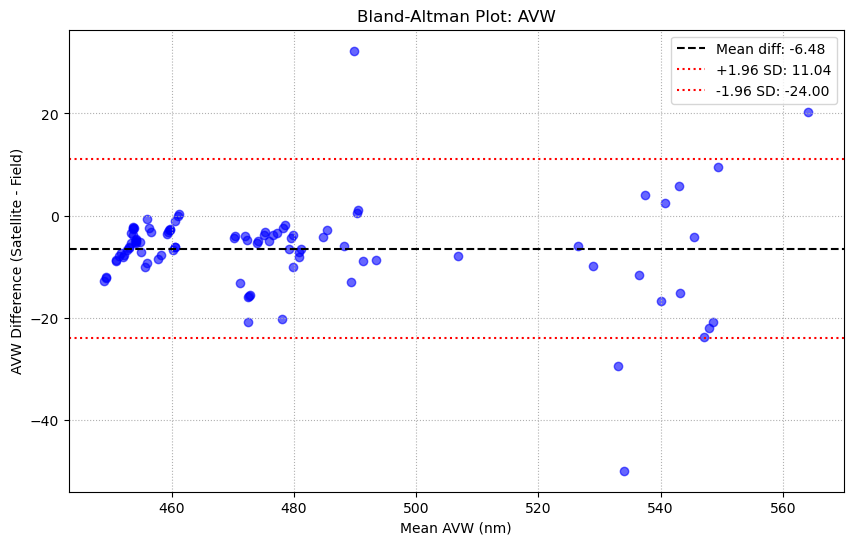

In [8]:
plot_avw_comparisons(avw_mean, avw_diff, wavelengths_field_vis, rrs_diff)

## Spectral different comparisons

Let's plot the spectral differences between PACE and the field measurements. The first plot will do so on the Rrs data "as is", showing us PACE - field spectra. The second plot may seem superfluous, but I think it is a useful diagnostic tool. The second plot basically takes spectral magnitude out of the picture, and allows you to examine the absoltue differnces in spectral shape. It's all in relative space, but let's you key in on the wavelength performance. Not the colorbar scale here, it is not a function of AVW, but the AVW difference between the original spectra. Note that the higher magnitude errors in shape correspond well to the AVW differences.

In [9]:
def plot_spectral_comparison(avw_diff, wavelengths, rrs_diff, rrs_diff2):
    #Plots side-by-side spectral differences: (1) original, (2) normalized, colored by AVW difference.
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True, gridspec_kw={'width_ratios': [1, 1]})
    cmap = plt.get_cmap('jet')
    
    # Symmetric color scale centered at 0
    max_abs = max(abs(np.min(avw_diff)), abs(np.max(avw_diff)))
    norm = plt.Normalize(vmin=-max_abs, vmax=max_abs)

    # --- Left Plot: Original rrs_diff ---
    ax1.set_title(f'Original Spectra Diff ({len(avw_diff)} samples)', fontsize=14)
    for mean_value, diff in zip(avw_diff, rrs_diff):
        color = cmap(norm(mean_value))
        ax1.plot(wavelengths, diff, color=color, alpha=0.6)

    ax1.set_xlabel('Wavelength (nm)', fontsize=12)
    ax1.set_ylabel(r'Rrs$_{\text{PACE}}$ - Rrs$_{\text{Field}}$ (sr$^{-1}$)', fontsize=12)
    ax1.axhline(0, color='k', linestyle='--', linewidth=1.5)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Right Plot: Normalized rrs_diff2 ---
    ax2.set_title(f'Normalized Spectra Diff ({len(avw_diff)} samples)', fontsize=14)
    for mean_value, diff in zip(avw_diff, rrs_diff2):
        color = cmap(norm(mean_value))
        ax2.plot(wavelengths, diff, color=color, alpha=0.6)

    ax2.set_xlabel('Wavelength (nm)', fontsize=12)
    ax2.set_ylabel(r'nRrs$_{\text{PACE}}$ - nRrs$_{\text{Field}}$ (sr$^{-1}$)', fontsize=12)
    ax2.axhline(0, color='k', linestyle='--', linewidth=1.5)
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- Clean Colorbar on the Side ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('AVW Difference (nm)', fontsize=12)

    plt.show()


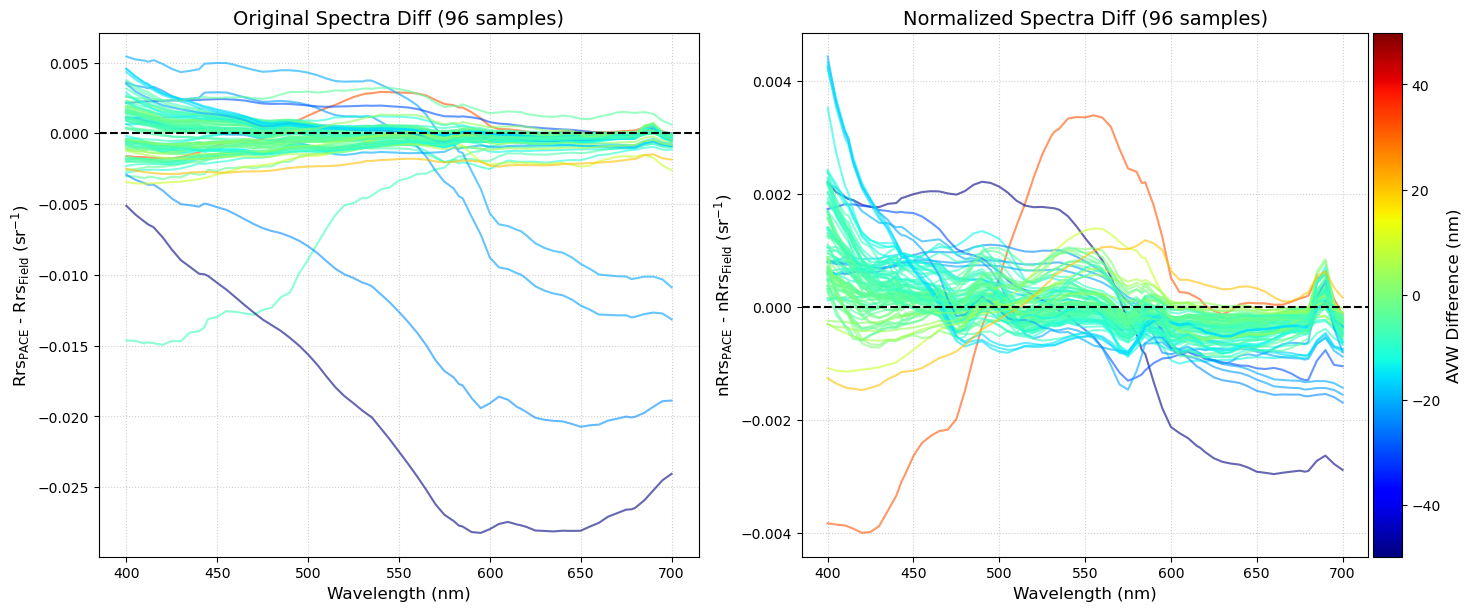

In [10]:
plot_spectral_comparison(avw_diff, wavelengths_field_vis, rrs_diff, rrs_diff_norm)

## Fun with Quadrants!

Another way to describe the behavior of the spectra is to intercompare the two primary elements - differences in spectral shape, and differences in spectral magnitude. This gives us a "birds-eye" view of PACE performance by dividing up the spectral behaviors into 4 categories: 

Relative to the field measurements:

> 1. PACE is red-shifted and brighter
> 2. PACE is red-shifted and dimmer
> 3. PACE is blue-shifted and brighter
> 4. PACE is blue-shifted and dimmer

In this case, we can see better visualize the tendency for PACE to be more blue shifted relative to field measurements. These criteria may be useful diagnostic tools to further assess conditions under which the spectral differences occur. 

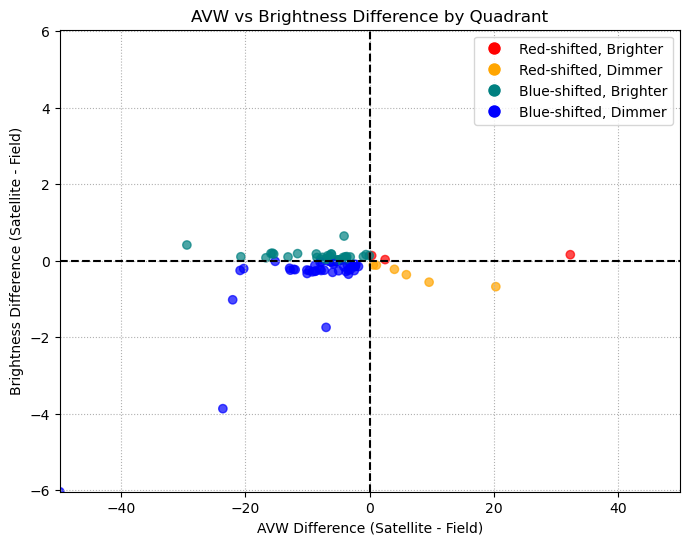

In [11]:
from matplotlib.lines import Line2D

# Optional: color points by quadrant
colors = []
for x, y in zip(avw_diff, brightness_diff):
    if x >= 0 and y >= 0:
        colors.append('red') # High AVW diff, High Brightness diff
    elif x < 0 and y >= 0:
        colors.append('teal') # Low AVW diff, High Brightness diff
    elif x < 0 and y < 0:
        colors.append('blue') # Low AVW diff, Low Brightness diff
    else:
        colors.append('orange') # High AVW diff, Low Brightness diff

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(avw_diff, brightness_diff, c=colors, alpha=0.7)

ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')
xlim = max(abs(avw_diff.min()), abs(avw_diff.max()))
ylim = max(abs(brightness_diff.min()), abs(brightness_diff.max()))
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

ax.set_xlabel('AVW Difference (Satellite - Field)')
ax.set_ylabel('Brightness Difference (Satellite - Field)')
ax.set_title('AVW vs Brightness Difference by Quadrant')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Red-shifted, Brighter', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Red-shifted, Dimmer', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Blue-shifted, Brighter', markerfacecolor='teal', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Blue-shifted, Dimmer', markerfacecolor='blue', markersize=10),
]
ax.legend(handles=legend_elements, loc='best')

plt.grid(True, linestyle=':')
plt.show()


## That's a wrap!